In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

import sys
sys.path.append("../includes")

import utils

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Define neighborhood mask

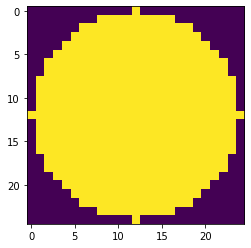

In [2]:
neighborhood = 25

center = neighborhood // 2

y, x = np.ogrid[-center : center + 1, -center : center + 1]
mask = torch.Tensor(x * x + y * y <= (neighborhood // 2) ** 2).bool()

neighborhood_kernel = torch.zeros(neighborhood, neighborhood).cuda()
neighborhood_kernel[mask] = 1

neighborhood_kernel = neighborhood_kernel[None, None, :]

plt.imshow(neighborhood_kernel[0, 0].cpu())

# Initialize model

In [3]:
class Automata(nn.Module):
    def __init__(self, grid_size, n_channels, hidden_size, device):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor(
            [
                [[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]],
                [[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]],
                [[[0, 0, 0], [0, 1, 0], [0, 0, 0]]],
            ]
        ).to(device)

        self.mapper = nn.Sequential(
            nn.Linear(3 * n_channels, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, n_channels),
            nn.Tanh(),
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="circular")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3 * self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.5

        return conved * can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]

        x.requires_grad = True

        prev = torch.zeros_like(x)

        for i in range(iterations):

            # get vitality of neighbors
            next_alive = (
                nn.functional.max_pool2d(x[:, 3], (3, 3), stride=1, padding=1) > 1 / 8
            )

            next_alive = next_alive.unsqueeze(1)

            alive_indicators = nn.functional.pad(
                x[:, 3][:, None], [neighborhood // 2] * 4, mode="circular"
            )
            
            # apply neighborhood filter to eliminate too-dense
            neighbor_density = nn.functional.conv2d(
                alive_indicators, neighborhood_kernel
            )
            neighbor_density = neighbor_density[:, 0]

            too_dense = neighbor_density.unsqueeze(1) < float(
                neighborhood_kernel.sum() * 0.25
            )

            # keep only cells that have some number of 
            # close neighbors, but not too many
            is_alive = next_alive * too_dense

            # apply the update
            x = x + checkpoint.checkpoint(self.perception, x)
            x = x * is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x.detach()

            # keep the penultimate state for
            # computing the stability loss
            if i == iterations - 2:
                prev = x.clone()

        return x, prev

# Train model

In [4]:
n_channels = 4
n_epochs = 250
lr = 0.001 # learning rate
batch_size = 8
hidden_size = 64

model = Automata((128, 128), n_channels, hidden_size, device).cuda()

losses = []

# initialize pool with seeds
seed = torch.zeros(n_channels, 128, 128).cuda()
seed[3:, 64, 64] = 1

criterion = nn.MSELoss(reduction="none")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):

    iterations = random.randint(125, 150)

    initial_states = seed[None, :].repeat(batch_size, 1, 1, 1)

    out, prev = model(initial_states, iterations, keep_history=True)

    optimizer.zero_grad()

    alives = out[:, 3]
    prev_alives = prev[:, 3]

    # use a multiplier to weight the vitality loss less
    vitality_loss = -alives.mean() * 0.1
    stability_loss = ((alives - prev_alives) ** 2).mean()

    loss = vitality_loss + stability_loss

    loss.backward()
    optimizer.step()

    if i % 10 == 0:

        print(i, float(loss.cpu().detach()))

    losses.append(float(loss))

0 -6.10351571594947e-06
10 -0.008034402504563332
20 -0.011073505505919456
30 -0.007254767697304487
40 -0.014240249991416931
50 -0.015265320427715778
60 -0.017484311014413834
70 -0.012835280038416386
80 -0.015436439774930477
90 -0.026257146149873734
100 -0.026160959154367447
110 -0.02619788981974125
120 -0.026670794934034348
130 -0.026894867420196533
140 -0.026841171085834503
150 -0.026750272139906883
160 -0.02684817835688591
170 -0.02639467641711235
180 -0.026765821501612663
190 -0.026824651286005974
200 -0.026566842570900917
210 -0.02643756940960884
220 -0.026859264820814133
230 -0.026452679187059402
240 -0.02697073109447956


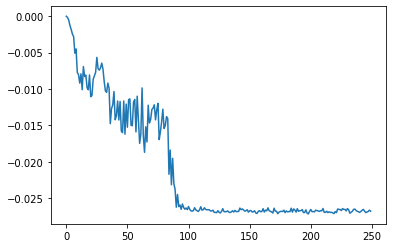

In [5]:
plt.plot(losses)

In [6]:
video = utils.get_model_history(model, seed, 512)
utils.channels_to_gif("../videos/optimization_channels.gif", video, row_channels=2, col_channels=2)
utils.colors_to_gif("../videos/optimization_colors.gif", video)

/home/khu/.cache/pypoetry/virtualenvs/neural-automata-mPApKxAd-py3.7/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
